In [ ]:
!pip install torch torch-geometric scikit-learn pandas networkx

In [ ]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class PretrainedGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PretrainedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.lin(x)
        return x


In [ ]:
!pip install gradio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Model definitions ===
class IoTModel(nn.Module):
    def __init__(self, input_dim=77, hidden_dim=128, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

class MalwareModel(nn.Module):
    def __init__(self, input_dim=55, hidden_dim=128, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

class PhishModel(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=128, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

class DDoSModel(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=128, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

# === Fusion classifier that concatenates logits from all models ===
class FusionClassifier(nn.Module):
    def __init__(self, num_models=4, output_dim=2,hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(num_models * output_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, logits_list):
        x = torch.cat(logits_list, dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

# === Instantiate models ===
iot_model = IoTModel().to(device)
malware_model = MalwareModel().to(device)
phish_model = PhishModel().to(device)
ddos_model = DDoSModel().to(device)
fusion_classifier = FusionClassifier(num_models=4).to(device)

# === Load pretrained weights ===
iot_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/iot/iot_model.pth", map_location=device), strict=False)
malware_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/malware/malware_model.pth", map_location=device), strict=False)
phish_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/phish/phish_model.pth", map_location=device), strict=False)
ddos_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/ddos/ddos_model.pth", map_location=device), strict=False)

# === Freeze pretrained models' parameters ===
for model in [iot_model, malware_model, phish_model, ddos_model]:
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

fusion_classifier.train()

# === Dummy dataset for fusion training ===
N = 100
x_iot_data = torch.randn(N, 77)
x_malware_data = torch.randn(N, 55)
x_phish_data = torch.randn(N, 16)
x_ddos_data = torch.randn(N, 8)
labels = torch.randint(0, 2, (N,))

dataset = TensorDataset(x_iot_data, x_malware_data, x_phish_data, x_ddos_data, labels)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(fusion_classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# === Training loop ===
train_losses = []
train_accuracies = []

for epoch in range(50):
    fusion_classifier.train()
    total_loss = 0
    correct = 0
    total = 0

    for xiot, xmal, xphish, xddos, y in loader:
        xiot = xiot.to(device)
        xmal = xmal.to(device)
        xphish = xphish.to(device)
        xddos = xddos.to(device)
        y = y.to(device)

        with torch.no_grad():
            logits_iot = iot_model(xiot)
            logits_malware = malware_model(xmal)
            logits_phish = phish_model(xphish)
            logits_ddos = ddos_model(xddos)

        optimizer.zero_grad()
        fused_logits = fusion_classifier([logits_iot, logits_malware, logits_phish, logits_ddos])
        loss = criterion(fused_logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(fused_logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# === Save the trained fusion model weights ===
torch.save(fusion_classifier.state_dict(), "/content/drive/My Drive/ids models/fusion_model.pth")
print("Fusion model saved!")

# === Function to load fusion model and perform inference ===
def load_fusion_model(path):
    model = FusionClassifier(num_models=4).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

# === Inference function using fusion model ===
def fusion_predict(xiot, xmal, xphish, xddos, fusion_model):
    iot_model.eval()
    malware_model.eval()
    phish_model.eval()
    ddos_model.eval()
    fusion_model.eval()

    with torch.no_grad():
        logits_iot = iot_model(xiot)
        logits_malware = malware_model(xmal)
        logits_phish = phish_model(xphish)
        logits_ddos = ddos_model(xddos)

        fused_logits = fusion_model([logits_iot, logits_malware, logits_phish, logits_ddos])
        probs = F.softmax(fused_logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    return preds, probs

# === Example usage after loading the saved fusion model ===
loaded_fusion_model = load_fusion_model("/content/drive/My Drive/ids models/fusion_model.pth")
torch.save({'model_state_dict': fusion_classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "/content/drive/My Drive/ids models/full_fusion_model.pth")


x_iot_test = torch.randn(5, 77).to(device)
x_malware_test = torch.randn(5, 55).to(device)
x_phish_test = torch.randn(5, 16).to(device)
x_ddos_test = torch.randn(5, 8).to(device)

preds, probs = fusion_predict(x_iot_test, x_malware_test, x_phish_test, x_ddos_test, loaded_fusion_model)
print("Predictions:", preds)
print("Probabilities:", probs)


Epoch 1 | Loss: 0.7524 | Accuracy: 0.5000
Epoch 2 | Loss: 0.6958 | Accuracy: 0.6000
Epoch 3 | Loss: 0.6794 | Accuracy: 0.6400
Epoch 4 | Loss: 0.6119 | Accuracy: 0.6500
Epoch 5 | Loss: 0.5928 | Accuracy: 0.6800
Epoch 6 | Loss: 0.5317 | Accuracy: 0.7500
Epoch 7 | Loss: 0.5449 | Accuracy: 0.7000
Epoch 8 | Loss: 0.5816 | Accuracy: 0.6600
Epoch 9 | Loss: 0.5209 | Accuracy: 0.7600
Epoch 10 | Loss: 0.5560 | Accuracy: 0.6600
Epoch 11 | Loss: 0.4766 | Accuracy: 0.7600
Epoch 12 | Loss: 0.5564 | Accuracy: 0.7400
Epoch 13 | Loss: 0.5932 | Accuracy: 0.7500
Epoch 14 | Loss: 0.5104 | Accuracy: 0.7900
Epoch 15 | Loss: 0.4417 | Accuracy: 0.7700
Epoch 16 | Loss: 0.4427 | Accuracy: 0.8000
Epoch 17 | Loss: 0.4184 | Accuracy: 0.8200
Epoch 18 | Loss: 0.3971 | Accuracy: 0.8200
Epoch 19 | Loss: 0.4504 | Accuracy: 0.8000
Epoch 20 | Loss: 0.4500 | Accuracy: 0.8200
Epoch 21 | Loss: 0.4549 | Accuracy: 0.7500
Epoch 22 | Loss: 0.5536 | Accuracy: 0.7200
Epoch 23 | Loss: 0.4893 | Accuracy: 0.7900
Epoch 24 | Loss: 0.4

In [ ]:
state_dict = torch.load("/content/drive/My Drive/ids models/fusion_model.pth", map_location=device)
print(state_dict.keys())


odict_keys(['fc1.weight', 'fc1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'fc2.weight', 'fc2.bias'])


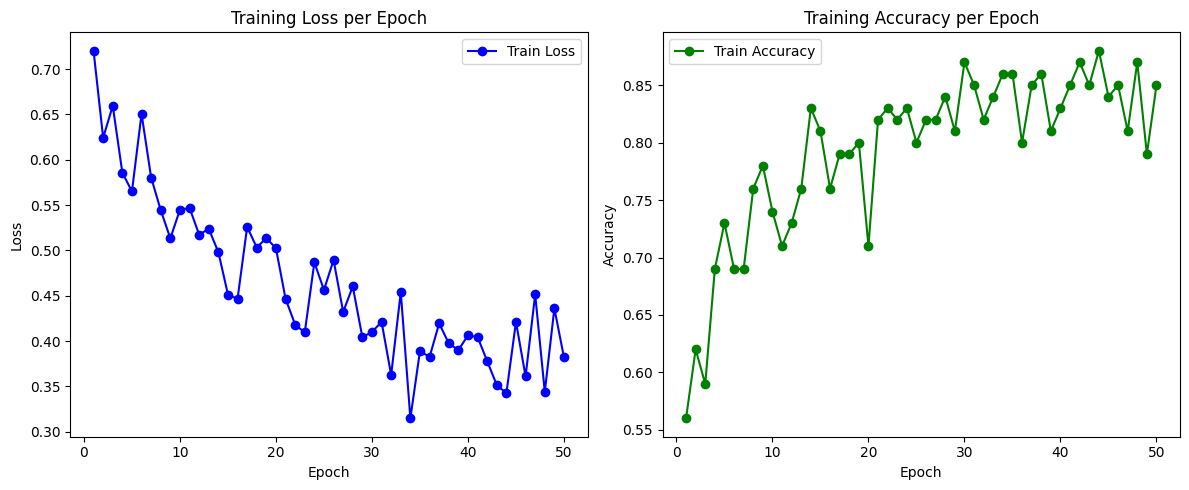

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g-o', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


Accuracy: 0.8800
Precision: 0.8529
Recall: 0.9667
F1 Score: 0.9062
Confusion Matrix:
[[30 10]
 [ 2 58]]


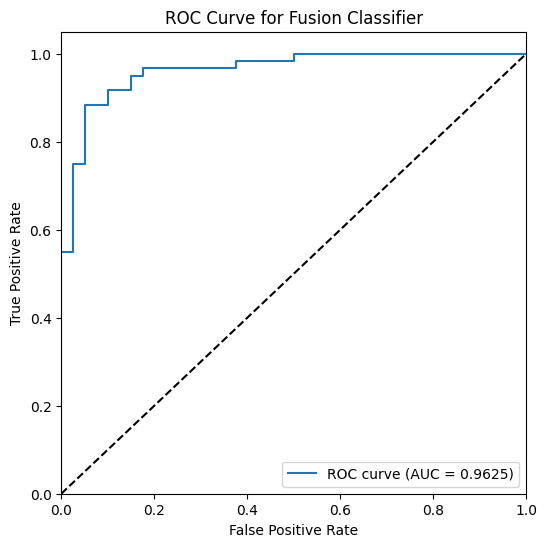

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
import numpy as np

# After your training loop, define an evaluation function:

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xiot, xmal, xphish, xddos, y in dataloader:
            xiot = xiot.to(device)
            xmal = xmal.to(device)
            xphish = xphish.to(device)
            xddos = xddos.to(device)
            y = y.to(device)

            logits_iot = iot_model(xiot)
            logits_malware = malware_model(xmal)
            logits_phish = phish_model(xphish)
            logits_ddos = ddos_model(xddos)

            fused_logits = model([logits_iot, logits_malware, logits_phish, logits_ddos])
            probs = F.softmax(fused_logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())  # Probabilities for class 1 (positive)
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Fusion Classifier')
    plt.legend(loc="lower right")
    plt.show()

# Call evaluation after training
evaluate_model(fusion_classifier, loader)


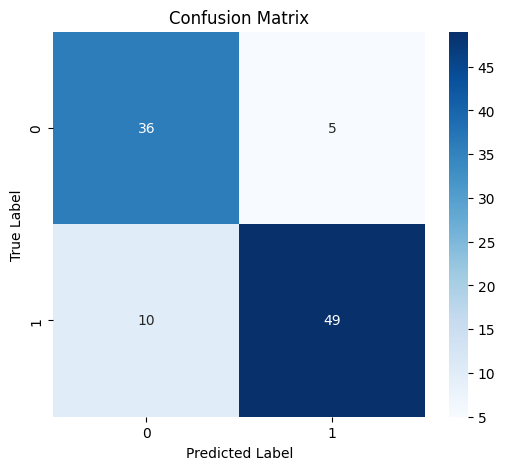

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Put model in eval mode
fusion_classifier.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xiot, xmal, xphish, xddos, y in loader:
        xiot = xiot.to(device)
        xmal = xmal.to(device)
        xphish = xphish.to(device)
        xddos = xddos.to(device)
        y = y.to(device)

        logits_iot = iot_model(xiot)
        logits_malware = malware_model(xmal)
        logits_phish = phish_model(xphish)
        logits_ddos = ddos_model(xddos)

        fused_logits = fusion_classifier([logits_iot, logits_malware, logits_phish, logits_ddos])
        preds = torch.argmax(fused_logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch

# Load the state dict
iot_weights = torch.load("/content/drive/My Drive/ids models/iot/iot_model.pth", map_location='cpu')
malware_weights = torch.load("/content/drive/My Drive/ids models/malware/malware_model.pth", map_location='cpu')
phish_weights = torch.load("/content/drive/My Drive/ids models/phish/phish_model.pth", map_location='cpu')
ddos_weights = torch.load("/content/drive/My Drive/ids models/ddos/ddos_model.pth", map_location='cpu')

# Print shapes of first layer weights
print("IoT input dim:", iot_weights["conv1.lin_l.weight"].shape[1])
print("Malware input dim:", malware_weights["conv1.lin_l.weight"].shape[1])
print("Phish input dim:", phish_weights["conv1.lin_l.weight"].shape[1])
print("DDoS input dim:", ddos_weights["conv1.lin_l.weight"].shape[1])


IoT input dim: 77
Malware input dim: 55
Phish input dim: 16
DDoS input dim: 8


In [ ]:
# Step 1: Install required libraries (if needed)
!pip install pandas scikit-learn

# Step 2: Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class IoTModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MalwareModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(55, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PhishModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DDoSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class FusionClassifier(nn.Module):
    def __init__(self, num_models=4, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(num_models * input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        x = torch.cat(inputs, dim=1)
        x = torch.relu(self.bn1(self.fc1(x)))
        return self.fc2(x)


In [ ]:
# Upload models manually
uploaded = files.upload()

# Load models
def load_models():
    iot_model = IoTModel(77).to(device)
    malware_model = MalwareModel().to(device)
    phish_model = PhishModel().to(device)
    ddos_model = DDoSModel().to(device)
    fusion_model = FusionClassifier().to(device)

    iot_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/iot/iot_model.pth", map_location=device), strict=False)
    malware_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/malware/malware_model.pth", map_location=device), strict=False)
    phish_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/phish/phish_model.pth", map_location=device), strict=False)
    ddos_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/ddos/ddos_model.pth", map_location=device), strict=False)
    fusion_model.load_state_dict(torch.load("/content/drive/My Drive/ids models/fusion_model.pth", map_location=device))

    for model in [iot_model, malware_model, phish_model, ddos_model]:
        model.eval()
        for param in model.parameters():
            param.requires_grad = False

    fusion_model.eval()
    return iot_model, malware_model, phish_model, ddos_model, fusion_model


Saving GroundTruth_IoT_GPS_Tracker(in) - GroundTruth_IoT_GPS_Tracker(in).csv to GroundTruth_IoT_GPS_Tracker(in) - GroundTruth_IoT_GPS_Tracker(in).csv


In [ ]:
def preprocess_file(file_path, expected_features):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        with open(file_path) as f:
            data = json.load(f)
            df = pd.json_normalize(data)

    def split_ip(ip_str):
        try:
            parts = ip_str.split('.')
            return [int(p) for p in parts] if len(parts) == 4 else [0]*4
        except:
            return [0]*4

    for col in ['src_ip', 'dst_ip']:
        if col in df.columns:
            ip_df = pd.DataFrame(df[col].apply(split_ip).tolist(), columns=[f"{col}_{i}" for i in range(1, 5)])
            df = pd.concat([df.drop(columns=[col]), ip_df], axis=1)

    for col in ['proto', 'type']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    if df.shape[1] > expected_features:
        df = df.iloc[:, :expected_features]
    else:
        for i in range(expected_features - df.shape[1]):
            df[f'pad_col_{i}'] = 0

    return torch.tensor(df.values, dtype=torch.float32).to(device)


In [ ]:
def fusion_inference(iot_tensor, malware_tensor, phish_tensor, ddos_tensor, models):
    iot_model, malware_model, phish_model, ddos_model, fusion_model = models

    with torch.no_grad():
        logits_iot = iot_model(iot_tensor)
        logits_malware = malware_model(malware_tensor)
        logits_phish = phish_model(phish_tensor)
        logits_ddos = ddos_model(ddos_tensor)

        fused_logits = fusion_model([logits_iot, logits_malware, logits_phish, logits_ddos])
        probs = F.softmax(fused_logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    return preds.cpu().numpy(), probs.cpu().numpy()


In [ ]:
# Upload your .csv or .json file
uploaded = files.upload()

# Assume uploaded file is 'input.csv'
input_file = list(uploaded.keys())[0]

# Preprocess
iot_tensor = preprocess_file(input_file, 77)
malware_tensor = preprocess_file(input_file, 55)
phish_tensor = preprocess_file(input_file, 16)
ddos_tensor = preprocess_file(input_file, 8)

# Load models
models = load_models()

# Run inference
preds, probs = fusion_inference(iot_tensor, malware_tensor, phish_tensor, ddos_tensor, models)

print("Predictions:", preds)
print("Probabilities:", probs)


Saving GroundTruth_Network_10(in) - GroundTruth_Network_10(in).csv to GroundTruth_Network_10(in) - GroundTruth_Network_10(in).csv
Predictions: [0 0 0 ... 0 0 0]
Probabilities: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
